In [27]:
!pip3 install matplotlib shapely dubins pyyaml descartes

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/Users/Luke/miniconda3/lib/python3.7/site-packages/numpy-1.21.2.dist-info/METADATA'



In [28]:
from __future__ import division

%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from shapely.strtree import STRtree
from environment import Environment, plot_environment, plot_line, plot_poly

import dubins
import heapq
import random
from search_classes import *
from utils import *
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motion Planning with Dynamic Constraints

The mad bomber from the 1994 movie Speed (https://www.youtube.com/watch?v=8piqd2BWeGI) strikes again! There's a bomb under the commuter bus that will explode if the bus goes under 50 mph. In order to detonate the bomb, the bus has to meet the bomb squad at the airport without stopping or hitting any obstacles on the way. Luckily, the bus happens to be an autonomous vehicle capable of performing motion planning.

We'll be solving this problem using the following methods: A* search, Constrained RRT and RRT*.


## Map and Obstacle Constraints
![map_motion](map.PNG)

Below is code that creates an easy and hard environment of Los Angeles, where the purple polygons represents landmarks/buildings. The green polygon represents the airport.

(-5, -4, 15, 5)
(12.063719280734986, 5.5)


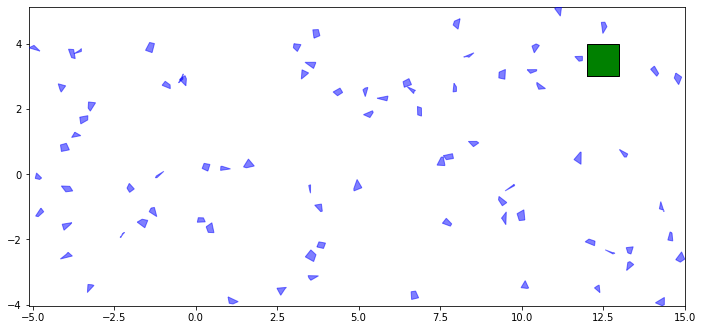

In [29]:
def random_environment(bounds, start, radius, goal, n, size_limits=(0.5, 1.5)):
    minx, miny, maxx, maxy = bounds
    print(bounds)
    edges = 4
    minl, maxl = size_limits
    env = Environment(None)
    obs = []
    start_pose = Point(start).buffer(radius, resolution=3)
    obi = 0
    while obi < n:
        r = np.random.uniform(low=0.0, high=1.0, size=2)
        xy = np.array([minx + (maxx-minx)*r[0], miny + (maxy-miny)*r[1]])
        
        angles = np.random.rand(edges)
        angles = angles*2*np.pi / np.sum(angles)
        for i in range(1,len(angles)):
            angles[i] = angles[i-1] + angles[i]
        angles = 2*np.pi * angles / angles[-1] 
        angles = angles + 2*np.pi*np.random.rand()
        lengths = 0.5*minl + (maxl-minl) * 0.5 * np.random.rand(edges)
        xx = xy[0] + np.array([l*np.cos(a) for a,l in zip(angles,lengths)])
        yy = xy[1] + np.array([l*np.sin(a) for a,l in zip(angles,lengths)])
        p = Polygon([(x,y) for x,y in zip(xx,yy)])
        if p.intersects(start_pose) or p.intersects(goal):
            continue
        else:
            obi = obi + 1
            obs.append(p)
#         coords = xy + [l*np.cos(a),l*np.sin(a) for a,l in zip(angles,lengths)]
    env.add_obstacles(obs)
    return env

start = (-4,-2, 2.5)
radius = 0.1
goal_region = Polygon([(12,3), (12,4), (13,4),(13,3)])
bounds = (-5, -4, 15, 5)
roadmap_env = random_environment(bounds, start, radius, goal_region, 80, (0.2, 0.4))
ax = plot_environment(roadmap_env)
plot_poly(ax, goal_region,'green')


TODO: Describe map?

In [44]:
def print_time(func):
    start_time = time.time()
    result = func()
    end_time = time.time()
    print("duration:", end_time - start_time,"s")
    return result

## Bus Motion Constraints

![bus_motion](car_motion.png)

Because the car has wheels that steer in either direction, we constrain its motion to arcs, specifically a Dubins path. Given the direction of the bus (in the image above, it's facing north), we can parametrize the range of its motion with $D$ degrees, which is the arc that it can forward in, and $R$, the turning radius. The state of the car will be represented as a tuple of length 3: (x coordinate, y coordinate, pose/direction).

In the image above, there are three different examples of the bus at possible states. When the bus is at the bottom-most state, the green area represents feasible states it can move to, and the red areas represent states that it cannot move to.

## Literature Review

We used the following resources to get more information on Dubins paths and how to handle the kinematic constraints of the bus.
- https://www.cs.cmu.edu/~motionplanning/lecture/lec21.pdf
- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9196964&tag=1

## Planning with Motion Primitives

One way to solve our motion planning problem is search. In order to take into consideration our constraints, we need to be careful about how we discretize our search space. A naive approach would simply divide the free configuration space into a grid. However, when we search this grid, we might create an infeasable path. The bus cannot drive backwards due to its constant speed. Similarly, the bus cannot reach the cell directly to the left and right.

A better discretization method would be to select from a precomputed list of "motion primitives." These are a list of actions from any state to a limited set of reachable states. This results in a tree starting at the first pose where the nodes are reachable states and the edges are actions the bus can take between those states. The number of actions in the motion primitive library are the branching factor for this tree. Nodes are pruned if the edge intersects an obstacle and A* is used to search the tree.

### Building the motion library  
We can build the motion primitives by calculating a series of dubins curves starting at the origin and ending at evenly spaced endpoints. These compiled actions will serve as the edges between poses in the search tree. The dubins library for python allows us to easily compute a dubins curve between two points.

In [30]:
def build_motion_library(sample_distance, angle_envelope, turning_radius, num_points, step_size = 0.01):
    motion_library = {} # format {weight : [path]}
    
    angle_step = 2*angle_envelope/(num_points - 1)
    for angle in np.arange(-angle_envelope, angle_envelope + angle_step, angle_step):
        q0 = (0,0,0)
        q1 = (np.cos(angle)*sample_distance, np.sin(angle)*sample_distance, angle)
        path = dubins.shortest_path(q0, q1, turning_radius)
        configuations, _ = path.sample_many(step_size)
        motion_library[angle] = (path.path_length(), configuations)
    return motion_library

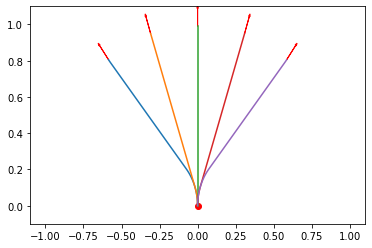

In [31]:
sample_distance = 1
# turning_radius = np.pi/40
turning_radius = np.pi/10
num_points = 5
angle_envelope = np.pi/5
motion_library = build_motion_library(sample_distance, angle_envelope, turning_radius, num_points)
plt.axis([-sample_distance*1.1, sample_distance*1.1, -sample_distance*0.1, sample_distance*1.1])
plt.plot([0],[0], 'ro' )
for motion in motion_library:
    path = motion_library[motion][1]
    x = [i[0] for i in path]
    y = [i[1] for i in path]
    last_pt = path[-1]
    plt.arrow(last_pt[1], last_pt[0],
              np.sin(last_pt[2])*sample_distance/10, np.cos(last_pt[2])*sample_distance/10,
              color='red', head_width = 0.01)
    plt.plot(y,x)
plt.show()

### Searching the tree

In [41]:
# check all the points along the path for collisions with the polygons in map
# we use a special data structure called strtree provided by shapely to quickly check for collisions
def checkNoCollision(path, env):
    for pose in path:
        point = Point(pose[0:2]).buffer(radius, resolution=3)
        # print(env.strtree.query(point))
        if len(env.strtree.query(point)) != 0:
            return False
    return True

# this is the heuristic
def dist_to_goal(pose, goal):
    return np.sqrt((pose[0]-goal[0])**2 + (pose[1]-goal[1])**2)

def expand_node(node, motion_library, world):
    start_pt = node.state
    for motion in motion_library.values():
        path = motion[1]
        dist = motion[0]
        extension = [(start_pt[0] + m[0], start_pt[1] + m[1], start_pt[2] + m[2]) for m in path]
        if checkNoCollision(extension, world):
            yield SearchNode(extension[-1], node, node.cost+dist, extension)

def test_goal(node, goal_region):
    point = Point(node[0:2]).buffer(radius, resolution=3)
    if goal_region.contains(point):
        return True
    return False

# Use the motion library to search for the goal with a euclidean distance heuristic
def search(start_pose, goal_region, motion_libary, world):
    motions = [i for i in motion_libary]
    goal_center = goal_region.centroid.coords[:][0]
    print(goal_center)
    startNode = SearchNode(start_pose)

    q = PriorityQueue(f=lambda node: dist_to_goal(node.state,goal_center)+node.cost)
    q.append(SearchNode(start_pose))
    expanded = set([startNode])

    max_q = 1
    path = list()
    iteration_count = 0
    while q and iteration_count < 50000:
        iteration_count += 1
        node = q.pop()
        if len(q) > max_q:
            max_q = len(q)
        if test_goal(node.state, goal_region):
            return Path(node), len(expanded), max_q

        if node in q:
            if q[node].cost > node.cost:
                del q[node]
                q.append(node)
            else:
                continue
        
        expanded.add(node)
        for neighbor in expand_node(node, motion_libary, world):
            if neighbor not in expanded:
                q.append(neighbor)
        
    return q, expanded, max_q

In [42]:
start_time = time.time()
search_result = print_time(lambda: search(start, goal_region, motion_library, roadmap_env))
end_time = time.time()

print("time elapsed:", end_time - start_time,"s")

(12.5, 3.5)
duration: 9.5367431640625e-07 s
time elapsed: 159.97259092330933 s


(12.063719280734986, 5.5)


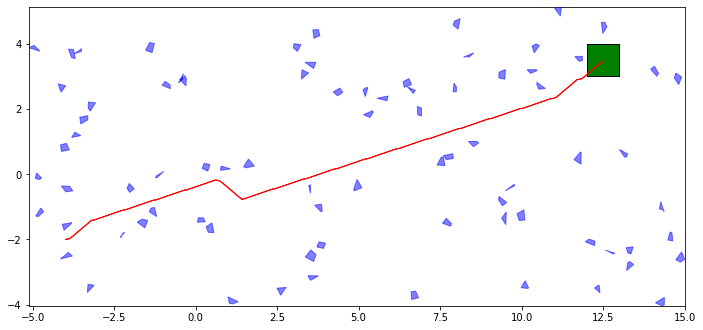

In [37]:
ax = plot_environment(roadmap_env)

plot_poly(ax, goal_region, "green")
for node1,node2 in search_result[0].edges():

    ax.plot([node1[0], node2[0]], [node1[1], node2[1]],
                            color='red', linewidth=1, solid_capstyle='round', zorder=1)


The path generated by A* and discretizing the actions takes over several minutes to run. Furthermore, it is stilll very choppy due to the low number of motions being considered by the planner. Clearly, a faster and smoother method is needed to generatee good trajectories.

## RRT with Kinematic Constraints

Discretizing the range of motion for the bus creates a tree with exponential size, and unfortunately, the bomb will detonate sooner than expected. Therefore, we need an algorithm that can plan a path to the airport, even if suboptimal, in a shorter amount of time. Instead of splitting the sample space into intervals, we consider Rapidly-exploring Random Trees (RRT), to explore the space more efficiently.

However, the main issue here is that if we sample a point anywhere in the environment, there is a chance that it is not reachable from the car's current location and pose via a linear path. Also, due to the bus's limited range of motion, we want to accomodate for those kinematics. Therefore, we propose the following pseudocode, which modifies the linear nature of traditional RRT:

- Sample randomly from the enviroment
- Find the closest point in the tree to the sampled point
- Draw a dublin path between the randomly sampled point and the neighboring point
    - If it hits an obstacle, then we resample
- If there's no obstacle in the way, then we add the sampled point to the tree
    - We will have a max length $L$, so we will cut the path off at $L$ if it is longer than $L$, and add the point at which the path is cut off to the tree instead
    - Note: the dublin path will essentially be in a 3D space because we have three parameters (x, y, pose)


In [60]:
def rrt(bounds, environment, start_pose, radius, end_region, sample_function,
        step_size=0.01, turning_radius = np.pi/20, d=0.5):  
    # RRT Helper Functions
    
    # Check to see if the path collides with an obstacle in the environment
    def checkNoCollision(path):
        for pose in path:
            point = Point(pose[0:2]).buffer(radius, resolution=3)
            # print(env.strtree.query(point))
            if len(environment.strtree.query(point)) != 0:
                return False
        return True
    
    # Finds the closest point that is already in the tree
    def nearest_neighbor(vertices, rand):
        min_dist = float('inf')
        closest_point = None
        path_from_closest = None
        for v in vertices:
            path = dubins.shortest_path(v, rand, turning_radius)
            if path.path_length() < min_dist:
                closest_point = v
                path_from_closest = path
                min_dist = path.path_length()
        # Return closest neighbor, the path from the closest neighbor to the sample point, and the configuration
        return closest_point, path_from_closest
    
    # Cuts the path off at distance 'd' to limit the size of the branches
    def steer(nearest, rand, path, d):
        dist = path.path_length()
        configuations, _ = path.sample_many(step_size)
        if dist < d: # If branch is already < d, then we can return the branch
            return configuations
        else:
            dist_so_far = 0
            new_path = [configuations[0]]
            # Iterate through the path and cut it off once the distance so far exceeds 'd'
            for i in range(len(configuations)-1):
                dist_so_far += np.sqrt((configuations[i][0] - configuations[i+1][0])**2 + (configuations[i][1] - configuations[i+1][1])**2)
                new_path.append(configuations[i+1])
                if dist_so_far >= d:
                    return new_path
            return new_path
        
    # Construct the path from the end to the start pose; plot the optimal path down the tree
    def construct_path(vertices, edges, end_pt, plot):
        path = [end_pt]
        path_len = 0
        while path[0] != start_pose:
            for edge in edges:
                if edge[1] == path[0]:
                    path = [edge[0]] + path
                    branch = dubins.shortest_path(edge[0], edge[1], turning_radius)
                    branch_pts, _ = branch.sample_many(step_size)
                    path_len += branch.path_length()
                    plot.plot([point[0] for point in branch_pts], [point[1] for point in branch_pts],
                            color='red', linewidth=2, solid_capstyle='round', zorder=1)
                    break
        return path, path_len
    
    # Code to run the RRT algorithm
    vertices = {start_pose}
    edges = set()
    ax = plot_environment(environment)
    plot_poly(ax, end_region, "green")
    while True: 
        rand_pt = sample_function(bounds, end_region, turning_radius)
        nearest, path = nearest_neighbor(vertices, rand_pt)
        new_path = steer(nearest, rand_pt, path, d)
        new_pt = new_path[-1]
        #We use the function from A* Search to check for obstacles
        if checkNoCollision(new_path):
            vertices.add(new_pt)
            edges.add((nearest, new_pt))
            ax.plot([point[0] for point in new_path], [point[1] for point in new_path], 
                            color='gray', linewidth=1, solid_capstyle='round', zorder=1)
            if end_region.contains(Point(new_pt[0:2])):
                path, path_len = construct_path(vertices, edges, new_pt, ax)
                ax.set_title(f"Nodes in tree: {len(vertices)}, Nodes in solution path: {len(path)}, Path length: {path_len}")
                return path
            
# Sample a random point within the bounds of the environment
def uninformed_sample(bounds, end_region, turning_radius):
    rand_pt = (random.uniform(bounds[0], bounds[2]),
               random.uniform(bounds[1], bounds[3]),
               random.uniform(0, turning_radius * 180/np.pi))
    return rand_pt
    

(12.063719280734986, 5.5)
duration: 1.1762688159942627 s


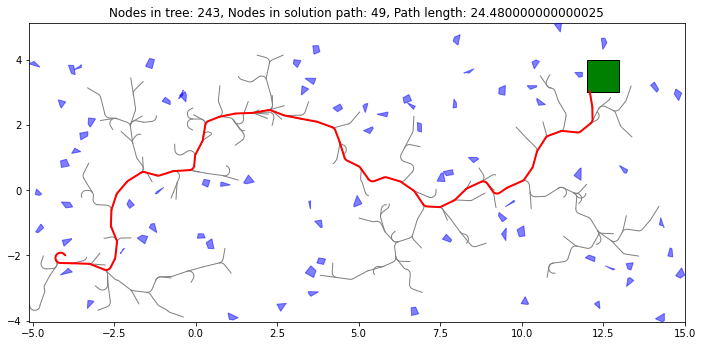

In [61]:
path = print_time(lambda: rrt(bounds, roadmap_env, start, radius, goal_region, uninformed_sample, step_size=0.01, turning_radius = np.pi/20, d=0.5))

### Incorporating Goal-directed Sampling

Since the autonomous bus has information about the area and knows where the goal state is, we implement a heuristic in the random sampling to find the airport faster. Essentially, with probability $p$, the algorithm will explore a new offshoot of the tree by randomly sampling. With probability $1-p$, the algorithm will sample in the direction and general location of the goal state. This way, we can exploit knowing the goal state while also exploring other parts of the environment.

In [52]:
def RRT_goal_directed(bounds, end_region, turning_radius, p=0.7):
    # p = 1 would be the same as the normal RRT implemented above
    if random.random() > p:
        # Algorithm samples in the goal
        minx, miny, maxx, maxy = end_region.bounds
        rand_pt = (random.uniform(minx, maxx),
                    random.uniform(miny, maxy),
                    random.uniform(0, turning_radius * 180/np.pi))
    else:
        # Standard RRT
        rand_pt = (random.uniform(bounds[0], bounds[2]),
               random.uniform(bounds[1], bounds[3]),
               random.uniform(0, turning_radius * 180/np.pi))
    return rand_pt
    

(12.063719280734986, 5.5)
duration: 1.6559898853302002 s


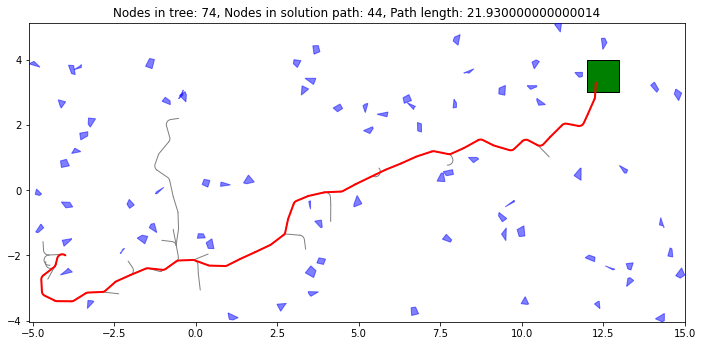

In [55]:
goal_directed_path = print_time(lambda: rrt(bounds, roadmap_env, start, radius, goal_region, RRT_goal_directed,
                         step_size=0.01, turning_radius = np.pi/20, d=0.5))

## RRT*

RRT* is an optimized version of RRT. The main difference is that every time we obtain a new point, we must check to see whether the paths of other nodes can be reduced by going through the new point. If so, we have to update our graph. Like RRT, we will be using the dubin library for path generation. 

In [ ]:
def uninformed_sample(bounds, end_region, turning_radius):
    # Sample a random point within the bounds of the environment
    rand_pt = (random.uniform(bounds[0], bounds[2]),
               random.uniform(bounds[1], bounds[3]),
               random.uniform(0, turning_radius * 180/np.pi))
    return rand_pt

def RRT_star(bounds, environment, start_pose, radius, end_region, sample_function, step_size=0.01,
        turning_radius = np.pi/20, d=0.5, N=100000):
    """
    Runs like RRT except it considers minimum cost paths and changes tree structure
    """
    print("starting program...\n")
    rad = 0.5
    def checkNoCollision(path):
        for pose in path:
            object = Point(pose[0:2]).buffer(radius, resolution=3)
            for obstacle in environment.obstacles:
                if object.intersects(obstacle):
                    return False
        return True
    
    def nearest_neighbor(vertices, rand):
        min_dist = float('inf')
        closest_point = None
        path_from_closest = None
        for v in vertices:
            path = dubins.shortest_path(v, rand, turning_radius)
            if path.path_length() < min_dist:
                closest_point = v
                path_from_closest = path
                min_dist = path.path_length()
        # Return closest neighbor, the path from the closest neighbor to the sample point, and the configuration
        return closest_point, path_from_closest
    
    def steer(nearest, rand, path, d):
        dist = path.path_length()
        configuations, _ = path.sample_many(step_size)
        if dist < d:
            return configuations, dist
        else:
            dist_so_far = 0
            new_path = [configuations[0]]
            for i in range(len(configuations)-1):
                dist_so_far += np.sqrt((configuations[i][0] - configuations[i+1][0])**2 + (configuations[i][1] - configuations[i+1][1])**2)
                new_path.append(configuations[i+1])
                if dist_so_far >= d:
                    return new_path, dist_so_far
            return new_path, dist_so_far
    
    def get_neighbors(vertices, x_new, rad, min_dist, nearest):
        neighbors = []
        best = nearest
        for v in vertices:
            path = dubins.shortest_path(v, x_new, turning_radius)
            if path.path_length() < rad:
                neighbors.append(v)
                if path.path_length() < min_dist:
                    best = v
                    min_dist = path.path_length()
        return neighbors
    def construct_path(parent, end_pt):
        # TODO: have it create path with parent dictionary not
        path = [end_pt]
        while path[0] != start_pose:
            path = [parent[path[0]]] + path
             branch = dubins.shortest_path(edge[0], edge[1], turning_radius)
                 branch_pts, _ = branch.sample_many(step_size)
                    path_len += branch.path_length()
                    plot.plot([point[0] for point in branch_pts], [point[1] for point in branch_pts],
                            color='red', linewidth=2, solid_capstyle='round', zorder=1)
        return path
    
    vertices = {start_pose}        # holds all vertices (x, y, rad)
    edges = set()                  # set of tuples: (start, end)
    cost = {start_pose: 0}         # distance each vertex has traveled relative to parent vertex
#     parent = {start_pose: None}    # maps each vertex to its parent vertex
    parent = {start_pose: None}
    ax = plot_environment(environment)
    plot_poly(ax, end_region, "green")
    
    for i in range(N):
        rand_pt = sample_function(bounds, end_region, turning_radius)
        nearest, path = nearest_neighbor(vertices, rand_pt)
        new_path, dist = steer(nearest, rand_pt, path, d)
        new_pt = new_path[-1]
        if checkNoCollision(new_path):
            vertices.add(new_pt)
            ax.plot([nearest[0], new_pt[0]], [nearest[1], new_pt[1]], 
                            color='gray', linewidth=1, solid_capstyle='round', zorder=1)
            cost[new_pt] = dist        # distance from new_pt to parent vertex (nearest)
            parent[new_pt] = nearest   # set parent node to be nearest vertex to new_pt
            x_neighbors = get_neighbors(vertices, new_pt, rad, dist, nearest)
            # reshape the tree
            for x_prime in x_neighbors:
                path_prime = dubins.shortest_path(x_prime, new_pt, turning_radius)
                configuations, _ = path_prime.sample_many(step_size)
                if checkNoCollision(configuations):
                    if cost[new_pt] + path_prime.path_length() < cost[x_prime]:
                        cost[x_prime] = cost[new_pt] + path_prime.path_length()
                        parent[x_prime] = new_pt
                        # plot the line
                        ax.plot([x_prime[0], new_pt[0]], [x_prime[1], new_pt[1]], 
                                color='gray', linewidth=1, solid_capstyle='round', zorder=1)
                    
            # check if point hit the goal 
            if end_region.contains(Point(new_pt[0:2])):
                print("goal reached\n")
                path = construct_path(parent, new_pt)
#                 path_len = 0
#                 for i in range(len(path)-1):
#                     ax.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]],
#                             color='red', linewidth=1, solid_capstyle='round', zorder=1)
#                     path_len += np.sqrt((path[i][0]-path[i+1][0])**2 + (path[i][1]-path[i+1][1])**2)
                ax.set_title(f"Nodes in tree: {len(vertices)}, Nodes in solution path: {len(path)}, Path length: {path_len}")
                return path
                    
        # x_rand = random point
        # use dubins to generate path between x_rand and bus
        
        # connect along minimum cost path
        
        # rewire the tree if paths with lower costs exist
        

starting program...

(11.937364183108917, 5.5)
goal reached

{(-4, -2, 2.5): None, (-4.153263391292131, -1.5210743139609577, 1.8087435549124513): (-4, -2, 2.5), (-3.9590597466252584, -1.057859923656277, 1.0980142727730078): (-4.153263391292131, -1.5210743139609577, 1.8087435549124513), (-4.320332428802729, -2.2746705830027825, 4.341886817138488): (-4, -2, 2.5), (-3.4847270964868224, -1.0170268889087384, 6.145901203194451): (-3.9590597466252584, -1.057859923656277, 1.0980142727730078), (-3.0602211438058697, -0.7531871948878702, 0.6483194000324959): (-3.4847270964868224, -1.0170268889087384, 6.145901203194451), (-2.5572933772957605, -0.7297134149860862, 6.262527270690613): (-3.0602211438058697, -0.7531871948878702, 0.6483194000324959), (-2.0613884454050315, -0.6125709566622541, 0.24258731669926537): (-2.5572933772957605, -0.7297134149860862, 6.262527270690613), (-1.5695748553077982, -0.47759333127205794, 0.2679527253947471): (-2.0613884454050315, -0.6125709566622541, 0.24258731669926537)

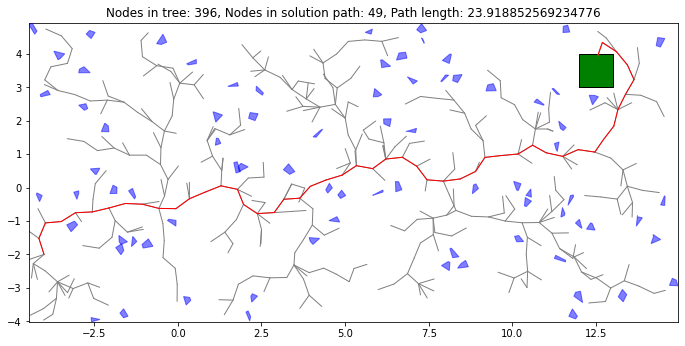

In [12]:
path = RRT_star(bounds, roadmap_env, start, radius, goal_region, uninformed_sample, step_size=0.01, turning_radius = np.pi/20, d=0.5)